In [ ]:
from functools import partial

import astroplan as ap
import astropy.units as u

from astropaul.database import database_connection
import astropaul.html as html
import astropaul.phase as ph
import astropaul.priority as pr
import astropaul.targetlistcreator as tlc

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
session = tlc.ObservingSession(ap.Observer.at_site("APO"))
session.add_full_day("2025-08-08")
session.add_full_day("2025-08-09")
session.add_full_day("2025-08-10")
session.add_full_day("2025-08-12")
session.add_full_day("2025-08-13")
session.add_half_day("2025-08-14", first_half=False)
session.add_half_day("2025-08-19", first_half=False)
session.add_half_day("2025-08-20", first_half=False)
session.add_full_day("2025-08-21")
session.add_half_day("2025-08-23", first_half=True)
session.add_half_day("2025-08-24", first_half=False)
session.add_half_day("2025-08-31", first_half=False)

synthetic_phase_percent = 0.02

phase_event_defs = [
    ph.PhaseEventDef("Mid Eclipse", ph.calc_mid_eclipse),
    ph.PhaseEventDef("Eclipse", ph.calc_mid_eclipse),
    ph.PhaseEventDef(
        "Not in Eclipse", partial(ph.calc_time_of_gress, synthetic_phase_percent=synthetic_phase_percent, ingress=False)
    ),
    ph.PhaseEventDef("Eclipse", partial(ph.calc_time_of_gress, synthetic_phase_percent=synthetic_phase_percent, ingress=True)),
]

min_altitude = 35 * u.deg
max_magnitude = 13

with database_connection() as conn:

    name = "APO Observing List 2025-08-08 to -13"
    creator = tlc.TargetListCreator(name=name, connection=conn)
    creator.steps = [
        tlc.add_targets,
        partial(tlc.filter_targets, criteria=lambda df: df["Target Type"].isin(["QuadEB", "SextEB"])),
        tlc.ancillary_data_from_tess,
        partial(tlc.filter_targets, criteria=lambda df: df["Vmag"] < max_magnitude),
        partial(
            tlc.add_observability,
            observing_session=session,
            calc_moon_distance=True,
            observability_threshold=(min_altitude, 80 * u.deg),
        ),
        partial(tlc.filter_targets, criteria=lambda df: df["Observable Any Night"]),
        partial(tlc.add_database_table, table_name="ephemerides"),
        partial(tlc.add_database_table, table_name="dssi_observations"),
        partial(
            tlc.add_system_configuration, table_name="DSSI Observations", time_column="Mid JD", eclipse_table="SIDE Observations"
        ),
        partial(tlc.add_database_table, table_name="speckle_detections"),
        partial(tlc.filter_targets, criteria=lambda df: df["Num Speckle Detections"] > 0),
        # partial(tlc.filter_other_list, list_name="Speckle Detections", criteria=lambda df: df["Separation"] < 0.1 * u.arcsec),
        partial(
            tlc.add_phase_events,
            observing_session=session,
            phase_event_defs=phase_event_defs,
            event_types=["Mid Eclipse", "Eclipse"],
        ),
    ]
    tl = creator.calculate(verbose=False)

    print(tl.summarize())
    # tl.target_list

Name: APO Observing List 2025-08-08 to -13
Criteria
    lambda df: df["Target Type"].isin(["QuadEB", "SextEB"])
    lambda df: df["Vmag"] < 13
    AltitudeConstraint: {'min': 35.0, 'max': 80.0, 'boolean_constraint': True}
    lambda df: df["Observable Any Night"]
    lambda df: df["Num Speckle Detections"] > 0
28 targets:
      28 QuadEB
Column Count (primary, secondary):
    Target: (3, 4)
    TESS Data: (2, 4)
    RV Data: (1, 2)
    Observable: (5, 48)
    Count: (4, 0)
Associated tables:
      12 rows,  2 columns: Lunar Phases
     250 rows,  7 columns: Ephemerides
     152 rows, 12 columns: DSSI Observations
      51 rows,  6 columns: SIDE Observations
     134 rows, 11 columns: Speckle Detections
    1491 rows, 10 columns: Phase Events



In [ ]:
html_dir = "../../../../Observing Files/APO Observing 2025-08-08"
html.clear_directory(html_dir)

altitude_categories = [
    ((-90, min_altitude.value), 0),
    ((min_altitude.value, 90), 1),
]

pl = pr.PriorityList(tl, session, interval=30 * u.min)
pr.calculate_altitude_priority(pl, altitude_categories=altitude_categories)
# pr.prioritize_phase_sequence(pl, ["Eclipse", "Mid Eclipse", "Eclipse"], "Eclipse", False, False, entirely_observable=True)
pr.prioritize_phase_sequence(pl, ["Eclipse"], "Eclipse", True, True, entirely_observable=False)
pr.prioritize_side_observation(pl, side_state="Eclipse")
pr.calculate_overall_priority(pl)
pr.aggregate_target_priorities(pl, skip_column_threshold=0.0)
pl.categorize_priorities(bins=[0.00, 0.20, 0.40, 0.6, 1.00], labels=["", "*", "* *", "* * *"])

html.render_observing_pages(tl, pl, {}, html_dir)
# pl.numerical_priorities[0]

In [1]:
import lightkurve as lk
import matplotlib.pyplot as plt

# Search for TESS light curves for a given target (name or TIC ID)
search_result = lk.search_lightcurve("TIC 344541836", mission="TESS")

# Show available products
print(search_result)

lcs = search_result.download_all()

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightkurve\prf\__init__.py:7: UserWarning: Warning: the tpfmodel submodule is not available without oktopus installed, which requires a current version of autograd. See #1452 for details.
  warnings.warn(


SearchResult containing 15 data products.

 #     mission     year   author  exptime target_name distance
                                     s                 arcsec 
--- -------------- ---- --------- ------- ----------- --------
  0 TESS Sector 84 2024      SPOC     120   344541836      0.0
  1 TESS Sector 56 2022 TESS-SPOC     200   344541836      0.0
  2 TESS Sector 57 2022 TESS-SPOC     200   344541836      0.0
  3 TESS Sector 76 2024 TESS-SPOC     200   344541836      0.0
  4 TESS Sector 77 2024 TESS-SPOC     200   344541836      0.0
  5 TESS Sector 15 2019       QLP    1800   344541836      0.0
  6 TESS Sector 17 2019       QLP    1800   344541836      0.0
  7 TESS Sector 56 2022       QLP     200   344541836      0.0
  8 TESS Sector 57 2022       QLP     200   344541836      0.0
  9 TESS Sector 76 2024       QLP     200   344541836      0.0
 10 TESS Sector 77 2024       QLP     200   344541836      0.0
 11 TESS Sector 84 2024       QLP     200   344541836      0.0
 12 TESS Sec

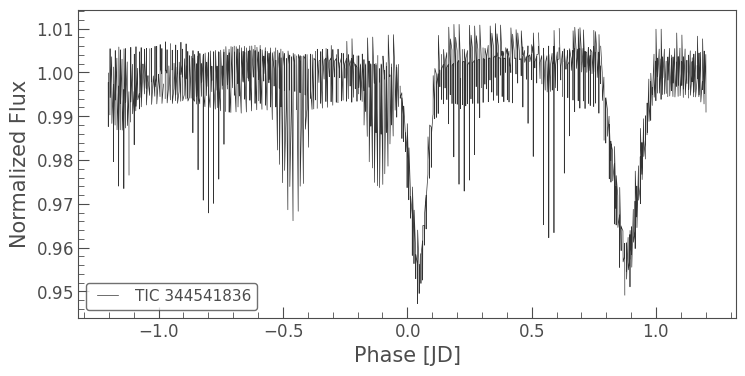

In [116]:
import matplotlib.pyplot as plt

lcs[0].fold(period=period * u.day).plot()
plt.show()

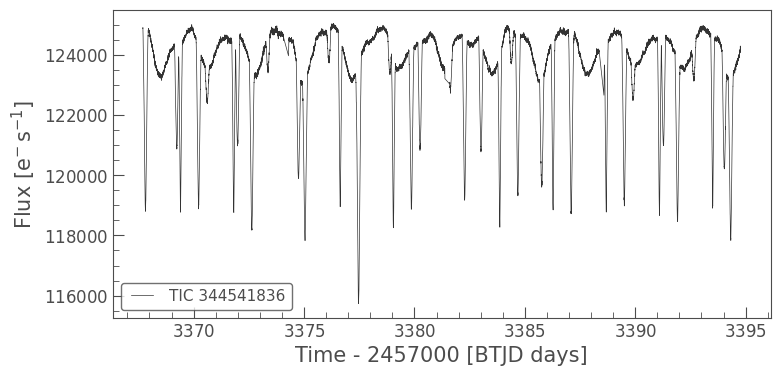

In [3]:
%matplotlib inline
lcs[3].plot()
plt.show()

In [106]:
from astropy.time import Time
import pandas as pd

t_kostov_Aa = Time(2458713.8429, format="jd")
t_kostov_Ab = Time(2458715.416345, format="jd")
t_orig = t_kostov_Ab
# 3 8-11
period = 2.409932
results = pd.DataFrame(columns=["Sector", "t_new UTC", "t_new", "day difference", "period difference", "hour offset"])
for lc in lcs:
    sector = lc.sector
    t_new = Time(lc.to_pandas()["flux"].idxmin() + 2457000, format="jd")
    delta = t_orig - t_new
    periods = delta.jd / period
    hours = periods % 1 * period
    results.loc[len(results)] = [sector, t_new.iso, t_new.jd - 2450000, delta.jd, periods, hours]
results

,Sector,t_new UTC,t_new,day difference,period difference,hour offset
0,15,2019-08-30 09:14:23.280,8725.884992,-10.468647,-4.343959,1.581013
1,15,2019-08-30 09:18:38.936,8725.887951,-10.471606,-4.345187,1.578054
2,15,2019-08-30 09:18:38.936,8725.887951,-10.471606,-4.345187,1.578054
3,17,2019-10-25 16:18:24.161,8782.179446,-66.763101,-27.703313,0.714995
4,56,2022-09-28 19:08:08.858,9851.297325,-1135.880980,-471.333208,1.606924
5,56,2022-09-28 19:08:10.818,9851.297347,-1135.881002,-471.333217,1.606902
6,57,2022-10-18 01:51:11.221,9870.577213,-1155.160868,-479.333387,1.606492
7,57,2022-10-18 01:51:13.141,9870.577235,-1155.160890,-479.333396,1.606470
8,76,2024-03-07 23:14:39.364,10377.468511,-1662.052166,-689.667661,0.800914
9,76,2024-03-07 23:11:21.345,10377.466219,-1662.049874,-689.666710,0.803206


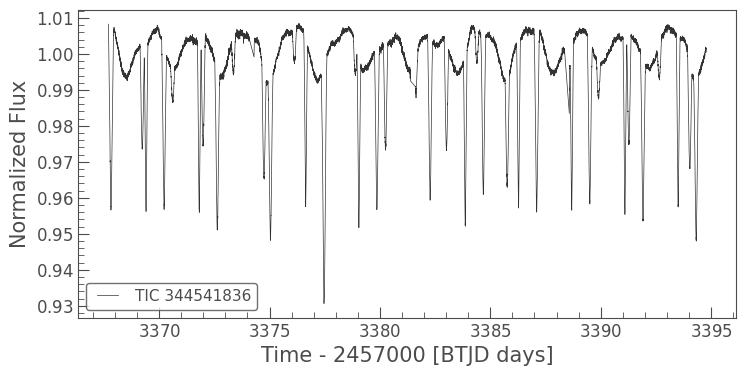

In [66]:
# Download the first light curve in the list
import matplotlib.pyplot as plt

lc = search_result[9].download()

# Plot it
lc.plot()
plt.show()

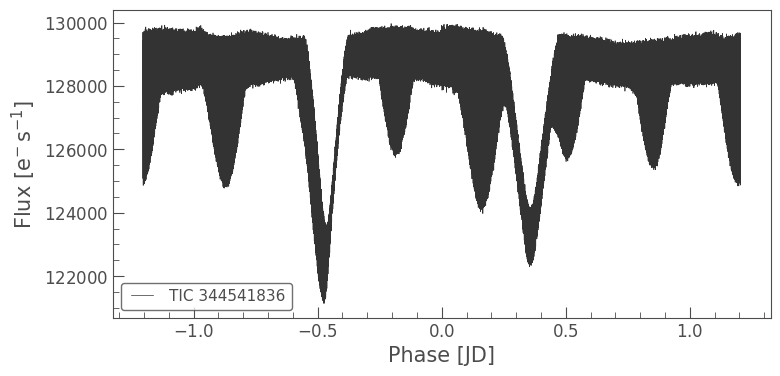

In [63]:
import astropy.units as u
import matplotlib.pyplot as plt

# lc.plot()
lc.fold(period=2.409932 * u.day).plot()
# lc.fold(period=2.755276 * u.day).plot()
plt.show()

In [64]:
from astropy.time import Time

t_obs = Time("2025-06-08 08:32:00", format="iso")
period = 2.409932
t_new = Time(lc.to_pandas()["flux"].idxmin() + 2457000, format="jd")
delta = t_obs - t_new
periods = (delta.jd / period)
hours = periods % 1 * period
t_new.jd, delta.jd, periods, hours

(2459851.2973247417,
 983.5582308138307,
 408.12696408605336,
 0.30597481383075253)